In [6]:
import cv2 as cv
from tensorflow.python.eager import backprop
from tensorflow.python.keras.engine import data_adapter
from tensorflow.python.keras.mixed_precision.experimental import loss_scale_optimizer as lso
from tensorflow.python.distribute import parameter_server_strategy
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle

import importlib
import copy

import os

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
plt.style.use('seaborn-whitegrid')

import time
import threading
try:
    from greenlet import getcurrent as get_ident
except ImportError:
    try:
        from thread import get_ident
    except ImportError:
        from _thread import get_ident
        
###Import self-written library
import featexlib.debug as dbug
import featexlib.datagen as dgen

In [23]:
class CameraEvent(object):
    """An Event-like class that signals all active clients when a new frame is
    available.
    """
    def __init__(self):
        self.events = {}

    def wait(self):
        """Invoked from each client's thread to wait for the next frame."""
        ident = get_ident()
        if ident not in self.events:
            # this is a new client
            # add an entry for it in the self.events dict
            # each entry has two elements, a threading.Event() and a timestamp
            self.events[ident] = [threading.Event(), time.time()]
        return self.events[ident][0].wait()

    def set(self):
        """Invoked by the camera thread when a new frame is available."""
        now = time.time()
        remove = None
        for ident, event in self.events.items():
            if not event[0].isSet():
                # if this client's event is not set, then set it
                # also update the last set timestamp to now
                event[0].set()
                event[1] = now
            else:
                # if the client's event is already set, it means the client
                # did not process a previous frame
                # if the event stays set for more than 5 seconds, then assume
                # the client is gone and remove it
                if now - event[1] > 5:
                    remove = ident
        if remove:
            del self.events[remove]

    def clear(self):
        """Invoked from each client's thread after a frame was processed."""
        self.events[get_ident()][0].clear()
        
        
class BaseCamera(object):
    thread = None  # background thread that reads frames from camera
    frame = None  # current frame is stored here by background thread
    last_access = 0  # time of last client access to the camera
    event = CameraEvent()

    def __init__(self):
        """Start the background camera thread if it isn't running yet."""
        if BaseCamera.thread is None:
            BaseCamera.last_access = time.time()

            # start background frame thread
            BaseCamera.thread = threading.Thread(target=self._thread)
            BaseCamera.thread.start()

            # wait until frames are available
            while self.get_frame() is None:
                time.sleep(0)

    def get_frame(self):
        """Return the current camera frame."""
        BaseCamera.last_access = time.time()

        # wait for a signal from the camera thread
        BaseCamera.event.wait()
        BaseCamera.event.clear()

        return BaseCamera.frame

    @staticmethod
    def frames():
        """"Generator that returns frames from the camera."""
        raise RuntimeError('Must be implemented by subclasses.')

    @classmethod
    def _thread(cls):
        """Camera background thread."""
        print('Starting camera thread.')
        frames_iterator = cls.frames()
        for frame in frames_iterator:
            BaseCamera.frame = frame
            BaseCamera.event.set()  # send signal to clients
            time.sleep(0)

            # if there hasn't been any clients asking for frames in
            # the last 10 seconds then stop the thread
            if time.time() - BaseCamera.last_access > 10:
                frames_iterator.close()
                print('Stopping camera thread due to inactivity.')
                break
        BaseCamera.thread = None
        

class Camera_compare(BaseCamera):
    video_source = 0

    @staticmethod
    def frames():
        camera = cv.VideoCapture(gstreamer_pipeline(flip_method=2), cv.CAP_GSTREAMER)
        
        if not camera.isOpened():
            raise RuntimeError('Could not start camera.')
        
        while True:
            # read current frame
            _, frame = camera.read()

            # Convert the image from BGR color (which OpenCV uses) to RGB color (which face_recognition uses)
            #rgb_frame = frame[:, :, ::-1]  
            yield frame

            
def gstreamer_pipeline(
    capture_width=816,
    capture_height=616,
    display_width=816,
    display_height=616,
    framerate=20,
    flip_method=2,
):
    return (
        "nvarguscamerasrc ! "
        "video/x-raw(memory:NVMM), "
        "width=(int)%d, height=(int)%d, "
        "format=(string)NV12, framerate=(fraction)%d/1 ! "
        "nvvidconv flip-method=%d ! "
        "video/x-raw, width=(int)%d, height=(int)%d, format=(string)BGRx ! "
        "videoconvert ! "
        "video/x-raw, format=(string)BGR ! appsink"
        % (
            capture_width,
            capture_height,
            framerate,
            flip_method,
            display_width,
            display_height,
        )
    )

Starting camera thread.


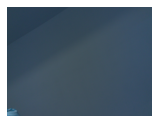

Stopping camera thread due to inactivity.


In [24]:
camera = Camera_compare()
frames = []
for i in range(1):
    frames.append(camera.get_frame())

dbug.Debug.show_images_list(frames, col_number = 4, height=2)    

In [13]:
print(gstreamer_pipeline(flip_method=2))

cap = cv.VideoCapture(gstreamer_pipeline(flip_method=2), cv.CAP_GSTREAMER)
if cap.isOpened():
    ret_val, img = cap.read()
    cap.release()
else:
    print("Unable to open camera")

    
   

nvarguscamerasrc ! video/x-raw(memory:NVMM), width=(int)816, height=(int)616, format=(string)NV12, framerate=(fraction)20/1 ! nvvidconv flip-method=2 ! video/x-raw, width=(int)816, height=(int)616, format=(string)BGRx ! videoconvert ! video/x-raw, format=(string)BGR ! appsink


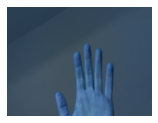

In [14]:
dbug.Debug.show_images_list([img], col_number = 4, height=2)  

In [2]:
camera = cv.VideoCapture(0)
if not camera.isOpened():
    raise RuntimeError('Could not start camera.')
_, frame = camera.read()

frame = cv.resize(frame, (640,480), interpolation = cv.INTER_AREA) 


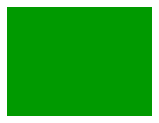

In [4]:
dbug.Debug.show_images_list([frame], col_number = 4, height=2) 